In [1]:
import numpy as np
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import set_time_step,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound
from celmech.disturbing_function import laplace_b as b

In [2]:
from celmech.secular import LaplaceLagrangeSystem
from celmech.poincare import Poincare

In [3]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [4]:
def make_sim(alpha, mass, ecc, pom):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu2, mu3 = mass
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = sim.particles[1].P/12
    sim.collision = "direct"
    
    return sim

In [10]:
def run(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
    R1 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*(1-alpha12)
    ec23 = alpha23**(-1/2)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    b12 = alpha12**(1/2)*alpha23**(-3/2)*2/(np.pi*(1-alpha12)**2)
    b23 = alpha23*2/(np.pi*(1-alpha23)**2)
    b13 = alpha13*2/(np.pi*(1-alpha13)**2)

    delta = (ec12*alpha23**(-1/8) - ec23*alpha12**(1/8))/ec13
    phi = -np.sqrt(mu1*mu2*mu3)*delta/(3/16+1/2*(mu3-mu1)*delta+3/8*delta**2)

    R2 = np.array([[np.cos(phi), -np.sin(phi), 0],
                [np.sin(phi), np.cos(phi), 0],
                [0,0,1]])
    R = R2@R1
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
    Gx, Gy = np.zeros((Nout,3)), np.zeros((Nout,3))
    for i, time in enumerate(times):
        sim.integrate(time)
        Gx[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.cos(-p.pomega) for p in ps[1:]]
        Gy[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.sin(-p.pomega) for p in ps[1:]]
    
    Sx = T.T @ Gx.T
    Sy = T.T @ Gy.T

    Sxapprox = R @ Gx.T
    Syapprox = R @ Gy.T
    
    G1, G2, G3 = np.sqrt(Gx**2 + Gy**2).T
    S1, S2, S3 = np.sqrt(Sx**2 + Sy**2)
    S1a, S2a, S3a = np.sqrt(Sxapprox**2 + Syapprox**2)
    
    return times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a

In [11]:
def norun(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    m_tot = m1 + m2 + m3
     
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*(1-alpha12)
    ec23 = alpha23**(-1/2)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    b12 = alpha12**(1/2)*alpha23**(-3/2)*2/(np.pi*(1-alpha12)**2)
    b23 = alpha23*2/(np.pi*(1-alpha23)**2)
    b13 = alpha13*2/(np.pi*(1-alpha13)**2)
    
    R1 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
#     prefac = - ps[3].n *m_tot/(4*(mu1+mu3))
#     w1 = prefac * (mu1*b12 + mu3*b23)
#     w1 = prefac * (mu1*alpha12**(1/2)*alpha23**(-3/2)*
#                    (mu2**2*b1(alpha12)+(mu1+mu3)**2*b1(alpha12) + 2*(mu1+mu3)*mu2*b2(alpha12))
#                   + mu3*alpha23*(mu2**2*b1(alpha23)+(mu1+mu3)**2*b1(alpha23)+2*mu2*(mu1+mu3)*b2(alpha23)))
#     w2 = prefac * (mu2*mu3*b12 + mu1*mu2*b23 + (mu1+mu3)**2*b13)
#     k = prefac * np.sqrt(mu1*mu2*mu3) * (b23*alpha23**(-1/4)-b12*alpha12**(1/4))
#     k = prefac * np.sqrt(mu1*mu2*mu3) * (-alpha12**(1/2)*alpha23**(-3/2)*(mu2*b1(alpha12)+(mu1+mu3)*alpha12**(1/4)*b2(alpha12))
#                                         +alpha23*(mu2*b1(alpha23)+(mu1+mu3)*alpha23**(-1/4)*b2(alpha23)))              
#     phi = 1/2*np.arctan2(2*k, w2-w1)

    delta = (ec12*alpha23**(-1/8) - ec23*alpha12**(1/8))/ec13
    phi = -np.sqrt(mu1*mu2*mu3)*delta/(3/16+1/2*(mu3-mu1)*delta+3/8*delta**2)

    R2 = np.array([[np.cos(phi), -np.sin(phi), 0],
                [np.sin(phi), np.cos(phi), 0],
                [0,0,1]])
    R = R2@R1
    
    Mdiagapprox = R1 @ lsys.Neccentricity_matrix @ R1.T
#     Mp = R2 @ Mdiagapprox @ R2.T
#     print('Mapprox eigenvals:', Mp[0][0],Mp[1][1],Mp[2][2])
#     print('Error:', (Mdiag[0][0]-Mp[0][0])/Mdiag[0][0], (Mdiag[1][1]-Mp[1][1])/Mdiag[1][1], (Mdiag[2][2]-Mp[2][2])/Mdiag[2][2])
    
#     print('-------------------------------------------------------------')
#     print('w1:', Mdiagapprox[0,0], w1, (Mdiagapprox[0,0]-w1)/Mdiagapprox[0,0])
#     print('w2:', Mdiagapprox[1,1], w2, (Mdiagapprox[1,1]-w2)/Mdiagapprox[1,1])
#     print('w2-w1:', Mdiagapprox[1,1]-Mdiagapprox[0,0], w2-w1, ((Mdiagapprox[1,1]-Mdiagapprox[0,0])-(w2-w1))/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
#     print('k:', Mdiagapprox[1,0], k, (Mdiagapprox[1,0]-k)/Mdiagapprox[1,0])
    
#     angle = 1/2*np.arctan(2*Mdiagapprox[1,0]/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
#     print('phi:', angle, phi, (angle-phi)/angle)
    return R

# Test the new S1'

In [12]:
from sympy import *
init_printing()
M1, M2, M3, Mstar, e12, e23, e13, b1_12, b1_23, b1_13, b2_12, b2_23, b2_13, alpha12, alpha23, alpha13, e1, e2, e3 = symbols("m1, m2, m3, Mstar, e_{12}, e_{23}, e_{13}, b1_{12}, b1_{23}, b1_{13}, b2_{12}, b2_{23}, b2_{13}, a_{12}, a_{23}, a_{13}, e_1, e_2, e_3", positive=True, real=True)
eps12, eps23, eps13 = symbols(r"\epsilon_{12}, \epsilon_{23}, \epsilon_{13}", positive=True, real=True)

G = Matrix([sqrt(M1)*e1, sqrt(M2)*e2, sqrt(M3)*e3])

### the eigenmodes by numerically diagonalizing M:

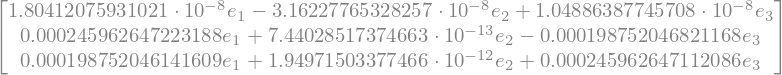

In [13]:
alpha = 0.75, 0.75
mass = 1e-7,1e-15,1e-7
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3
sim = make_sim(alpha, mass, ecc, pomega)
ps = sim.particles
lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
M = lsys.Neccentricity_matrix
vals,T = np.linalg.eigh(M)

T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2])

### the calculated eigenmodes:

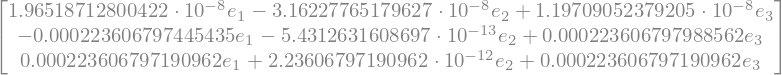

In [14]:
R = norun(sim)
R*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2])

### check with NBody

In [15]:
sim = make_sim(alpha, mass, ecc, pomega)
times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)

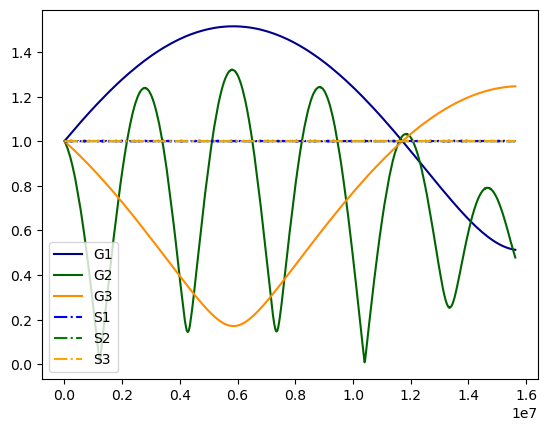

In [16]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], color='darkblue', label='G1')
ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1/S1[0], color='blue', linestyle='-.', label='S1')
ax.plot(times, S2/S2[0], color='green', linestyle='-.', label='S2')
ax.plot(times, S3/S3[0], color='orange', linestyle='-.', label='S3')
ax.legend()

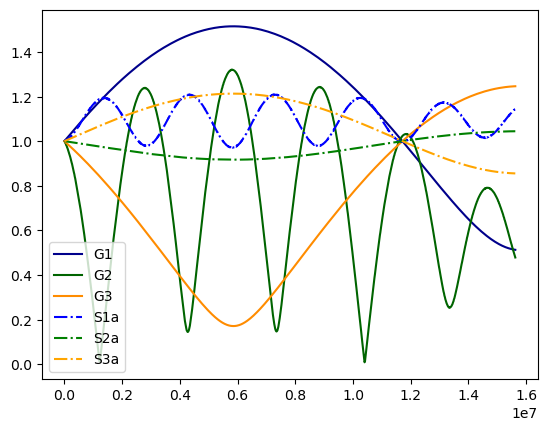

In [17]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], color='darkblue', label='G1')
ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1a/S1a[0], color='blue', linestyle='-.', label='S1a')
ax.plot(times, S2a/S2a[0], color='green', linestyle='-.', label='S2a')
ax.plot(times, S3a/S3a[0], color='orange', linestyle='-.', label='S3a')
ax.legend()

# Test psi approximations

In [18]:
def testPsi(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    m_tot = m1 + m2 + m3
     
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    b12 = alpha12**(1/2)*alpha23**(-3/2)*2/(np.pi*(1-alpha12)**2)
    b23 = alpha23*2/(np.pi*(1-alpha23)**2)
    b13 = alpha13*2/(np.pi*(1-alpha13)**2)
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*(1-alpha12)
    ec23 = alpha23**(-1/2)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    R2 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    Mdiagapprox = R2 @ lsys.Neccentricity_matrix @ R2.T
    phi_theo = 1/2*np.arctan(2*Mdiagapprox[1,0]/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
    
    prefac = - ps[3].n *m_tot/(4*(mu1+mu3))
    w1 = prefac * (mu1*b12 + mu3*b23)
    w2 = prefac * (mu2*mu3*b12 + mu1*mu2*b23 + (mu1+mu3)**2*b13)
    k = prefac * np.sqrt(mu1*mu2*mu3) * (b23*alpha23**(-1/4)-b12*alpha12**(1/4))
    phi_calc = 1/2*np.arctan2(2*k, w2-w1)

    delta = (ec12*alpha23**(-1/8) - ec23*alpha12**(1/8))/ec13
    phi_saa2 = -np.sqrt(mu1*mu2*mu3/(mu1+mu3)**4)*delta/(3/16+1/2*(mu3-mu1)*delta+3/8*delta**2)
    phi_saa1 = -16/3*np.sqrt(mu1*mu2*mu3)*delta

#     print(delta, phi, phi_approx, (phi-phi_approx)/phi)
    return delta, phi_theo, phi_calc, phi_saa1, phi_saa2, (phi_theo-phi_saa1)/phi_theo, (phi_theo-phi_saa2)/phi_theo

In [19]:
mass_param = [[x,y] for x in np.linspace(1,10,2) for y in np.linspace(1,10,2)]
alpha_param = [[x,y] for x in np.linspace(0.75,0.95,4) for y in np.linspace(0.75,0.95,4)]
# alpha_param = np.array([[0.99, 0.75]])
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3

data = np.zeros((64,11))
for i, (alpha1, alpha2) in enumerate(alpha_param):
    for j, (m1, m3) in enumerate(mass_param):
        mass = m1*1e-7, 1e-15, m3*1e-7
        sim = make_sim((alpha1, alpha2), mass, ecc, pomega)
        delta, phi_theo, phi_calc, phi_saa1, phi_saa2, error1, error2 = testPsi(sim)

        data[4*i+j][:] = m1, m3, alpha1, alpha2, delta, phi_theo, phi_calc, phi_saa1, phi_saa2, np.fabs(error1), np.fabs(error2)

In [23]:
pd.set_option('display.max_rows', 25)
df = pd.DataFrame(data, columns=['m1', 'm3', r'$\alpha_{12}$', r'$\alpha_{23}$', '$\Delta$', '$\phi_{theo}$', '$\phi_{calc}$', '$\phi_{saa1}$', '$\phi_{saa2}$', 'error1', 'error2'])
df['$\phi_{theo}$'] = df['$\phi_{theo}$'].map('{:e}'.format)
df['$\phi_{calc}$'] = df['$\phi_{calc}$'].map('{:e}'.format)
df['$\phi_{saa1}$'] = df['$\phi_{saa1}$'].map('{:e}'.format)
df['$\phi_{saa2}$'] = df['$\phi_{saa2}$'].map('{:e}'.format)
df

,m1,m3,$\alpha_{12}$,$\alpha_{23}$,$\Delta$,$\phi_{theo}$,$\phi_{calc}$,$\phi_{saa1}$,$\phi_{saa2}$,error1,error2
0,1.0,1.0,0.75,0.750000,-0.092649,1.701170e-05,1.792008e-05,1.747002e-05,1.717516e-05,0.026941,0.009609
1,1.0,10.0,0.75,0.750000,-0.092649,5.945442e-06,6.086139e-06,4.283037e-06,5.255106e-06,0.279610,0.116112
2,10.0,1.0,0.75,0.750000,-0.092649,3.130386e-06,3.437318e-06,4.283012e-06,3.512652e-06,0.368206,0.122115
3,10.0,10.0,0.75,0.750000,-0.092649,5.379554e-06,5.666857e-06,5.524536e-06,5.431293e-06,0.026951,0.009618
4,1.0,1.0,0.75,0.816667,0.082802,-1.531668e-05,-1.637853e-05,-1.561322e-05,-1.540202e-05,0.019360,0.005572
...,...,...,...,...,...,...,...,...,...,...,...
59,10.0,10.0,0.95,0.883333,-0.435563,1.915587e-05,1.888767e-05,2.597196e-05,1.882803e-05,0.355822,0.017114
60,1.0,1.0,0.95,0.950000,-0.018743,3.852201e-06,3.561592e-06,3.534264e-06,3.531782e-06,0.082534,0.083178
61,1.0,10.0,0.95,0.950000,-0.018746,1.062719e-06,9.241019e-07,8.666086e-07,9.029035e-07,0.184536,0.150383
62,10.0,1.0,0.95,0.950000,-0.018743,8.405559e-07,8.276849e-07,8.664727e-07,8.318694e-07,0.030833,0.010334


In [ ]:
df.to_csv("psiTest.csv",index=False)

# Test eigenmodes approximation

In [ ]:
def testModes(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    m_tot = m1 + m2 + m3
     
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*(1-alpha12)
    ec23 = alpha23**(-1/2)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    b12 = alpha12**(1/2)*alpha23**(-3/2)*2/(np.pi*(1-alpha12)**2)
    b23 = alpha23*2/(np.pi*(1-alpha23)**2)
    b13 = alpha13*2/(np.pi*(1-alpha13)**2)
    
    R1 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    prefac = - ps[3].n *m_tot/(4*(mu1+mu3))
    w1 = prefac * (mu1*b12 + mu3*b23)
    w2 = prefac * (mu2*mu3*b12 + mu1*mu2*b23 + (mu1+mu3)**2*b13)
    k = prefac * np.sqrt(mu1*mu2*mu3) * (b23*alpha23**(-1/4)-b12*alpha12**(1/4))
    phi = 1/2*np.arctan2(2*k, w2-w1)    
    
    R2 = np.array([[np.cos(phi), -np.sin(phi), 0],
                [np.sin(phi), np.cos(phi), 0],
                [0,0,1]])
    R = R2 @ R1
    
    delta = (ec12*alpha23**(-1/8) - ec23*alpha12**(1/8))/ec13
    
    return R, delta

In [ ]:
def convert(expression, mu):
    coeff1 = expression.split("*")[0]
    coeff1 = float(coeff1)
    coeff2 = (expression.split("*")[1]).split("e_1")[1]
    coeff2 = float(coeff2.replace(" ", ""))
    coeff3 = (expression.split("+")[1]).split("*")[0]
    coeff3 = float(coeff3)
    
    mu1, mu2, mu3 = mu
    
    A = np.array([[mu1, -1, mu1],[-(mu1+mu3), 0, mu2],[mu3, 1, mu3]])
    b = np.array([coeff1, coeff2, coeff3])
    x = np.linalg.solve(A, b)
    return x

In [ ]:
M1, M2, M3, Mstar, e12, e23, e13, b1_12, b1_23, b1_13, b2_12, b2_23, b2_13, alpha12, alpha23, alpha13, e1, e2, e3 = symbols("m1, m2, m3, Mstar, e_{12}, e_{23}, e_{13}, b1_{12}, b1_{23}, b1_{13}, b2_{12}, b2_{23}, b2_{13}, a_{12}, a_{23}, a_{13}, e_1, e_2, e_3", positive=True, real=True)
eps12, eps23, eps13 = symbols(r"\epsilon_{12}, \epsilon_{23}, \epsilon_{13}", positive=True, real=True)
G = Matrix([sqrt(M1)*e1, sqrt(M2)*e2, sqrt(M3)*e3])

In [ ]:
alpha = 0.75, 0.9
mass = 10e-7,1e-15,1e-7
m_tot = mass[0]+mass[1]+mass[2]
mu1, mu2, mu3 = mass[0]/m_tot, mass[1]/m_tot, mass[2]/m_tot
ecc = 0.005, 0.005, 0.005
pomega = 0, 0, np.pi
sim = make_sim(alpha, mass, ecc, pomega)

### numerically calculated

In [ ]:
lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
M = lsys.Neccentricity_matrix
vals,T = np.linalg.eigh(M)

exp_theo = (T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[0]
convert(str(exp_theo), (mu1,mu2,mu3))

### k, w1, w2 approximation

In [ ]:
R, delta = testModes(sim)
exp_approx = (R*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[0]
convert(str(exp_approx), (mu1,mu2,mu3))

### delta approximation

In [ ]:
np.array([np.sqrt(mass[1]), np.sqrt(mass[1])*(mu1*mu3*delta/(3/16+1/2*(mu3-mu1)*delta+3/8*delta**2))])

### NBody test

In [ ]:
mass_param = [[x,y] for x in np.linspace(1,10,2) for y in np.linspace(1,10,2)]
alpha_param = [[x,y] for x in np.linspace(0.75,0.9,4) for y in np.linspace(0.75,0.9,4)]
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3

fig, ax = plt.subplots(64,2, figsize=(12, 200))
data = np.zeros((64,7))
for i, (alpha1, alpha2) in enumerate(alpha_param):
    for j, (m1, m3) in enumerate(mass_param):
        mass = m1*1e-7, 1e-15, m3*1e-7
        sim = make_sim((alpha1, alpha2), mass, ecc, pomega)
        times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)
        ax[i*4+j,0].plot(times, G1/G1[0], color='darkblue', label='G1')
        ax[i*4+j,0].plot(times, G2/G2[0], color='darkgreen', label='G2')
        ax[i*4+j,0].plot(times, G3/G3[0], color='darkorange', label='G3')
        ax[i*4+j,0].plot(times, S1/S1[0], color='blue', linestyle='-.', label='S1')
        ax[i*4+j,0].plot(times, S2/S2[0], color='green', linestyle='-.', label='S2')
        ax[i*4+j,0].plot(times, S3/S3[0], color='orange', linestyle='-.', label='S3')
        ax[i*4+j,0].set_title(fr"$m_1$={m1},$m_3$={m3},$\alpha_{1}$={alpha1},$\alpha_{2}$={alpha2}")
        ax[i*4+j,0].get_xaxis().set_visible(False)

        ax[i*4+j,1].plot(times, G1/G1[0], color='darkblue', label='G1')
        ax[i*4+j,1].plot(times, G2/G2[0], color='darkgreen', label='G2')
        ax[i*4+j,1].plot(times, G3/G3[0], color='darkorange', label='G3')
        ax[i*4+j,1].plot(times, S1a/S1a[0], color='blue', linestyle='-.', label='S1a')
        ax[i*4+j,1].plot(times, S2a/S2a[0], color='green', linestyle='-.', label='S2a')
        ax[i*4+j,1].plot(times, S3a/S3a[0], color='orange', linestyle='-.', label='S3a')
        ax[i*4+j,1].get_xaxis().set_visible(False)

        amp_G, amp_S, amp_Sa = (max(G1)-min(G1))/(2*np.mean(G1)), (max(S1)-min(S1))/(2*np.mean(S1)), (max(S1a)-min(S1a))/(2*np.mean(S1a))
        data[i*4+j][:] = m1, m3, alpha1, alpha2, amp_G, amp_S, amp_Sa

fig.savefig('compare.png')

In [ ]:
df = pd.DataFrame(data, columns=['m_1','m_3',r'$\alpha_{12}$',r'$\alpha_{23}$','G','S','Sa'], index=None)
df

In [ ]:
df.to_csv("ModeAmp.csv",index=False)

-----------------------------------------------------------------------------------------------------------------

In [ ]:
def compareModes(sim, mass, mu):
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M)
    exp_theo = (T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[0]
    coeff_theo = convert(str(exp_theo), mu)
    
    R, delta = testModes(sim)
    exp_approx = (R*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[0]
    coeff_approx = convert(str(exp_approx), mu)
    
    mu1, mu2, mu3 = mu
    coeff_saa = np.array([np.sqrt(mass[1]), np.sqrt(mass[1])*(mu1*mu3*delta/(3/16+1/2*(mu3-mu1)*delta+3/8*delta**2))])
    
    return coeff_theo[0:2], coeff_approx[0:2], coeff_saa

In [ ]:
mass_param = [[x,y] for x in np.linspace(1,10,3) for y in np.linspace(1,10,3)]
alpha_param = [[x,y] for x in np.linspace(0.75,0.95,10) for y in np.linspace(0.75,0.95,10)]
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3

data = np.zeros((900,12))
for i, (alpha1, alpha2) in enumerate(alpha_param):
    for j, (m1, m3) in enumerate(mass_param):
        mass = m1*1e-7, 1e-15, m3*1e-7
        m_tot = mass[0]+mass[1]+mass[2]
        mu = (mass[0]/m_tot, mass[1]/m_tot, mass[2]/m_tot)
        
        sim = make_sim((alpha1, alpha2), mass, ecc, pomega)
        compareModes(sim, mass, mu)
        theo, approx, saa = compareModes(sim, mass, mu)
        data[i*9+j][:] = m1, m3, alpha1, alpha2, theo[0], approx[0], saa[0], np.fabs((theo[0]-saa[0])/theo[0]), theo[1], approx[1], saa[1], np.fabs((theo[1]-saa[1])/theo[1])

In [ ]:
df = pd.DataFrame(data, columns=['$m_1$', '$m_3$', r'$\alpha_{12}$',r'$\alpha_{23}$','co1$_{theo}$','co1$_{approx}$','co1$_{saa}$','$err1$','co2$_{theo}$','co2$_{approx}$','co2$_{saa}$','$err2$'], index=None)
df

In [ ]:
df.to_csv("ErrInMode(vectorDiff).csv",index=False)